# Preparing visuals

## Loading everything

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.data_loaders import get_data_loaders
import dgl
import networkx as nx
import os
import pandas as pd
import torch
import matplotlib.pyplot as plt
from src.py2graph import py2graph_helper
from src.preprocessing import augment_edge
from src.method_name_prediction import MethodNamePredictor
from src.graph_representation.node_encoder import ASTNodeEncoder

/gpfs/users/prevotb/.conda/envs/mlns/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_loader, valid_loader, test_loader, vocab2idx, idx2vocab = get_data_loaders(
    data_path="/workdir/shared/pulmembol/ogb-code2-preprocessed",
    batch_size=1024,
    max_seq_len=5,
    num_vocab=5000,
    num_workers=1,
)

Coverage of top 5000 vocabulary:
0.9025832389087423
Target sequence less or equal to 5 is 98.742% of the dataset.


In [4]:
idx2type = pd.read_csv(
    os.path.join("/workdir/shared/pulmembol/ogbg_code2/mapping/typeidx2type.csv.gz")
)
type2idx = {t: i for i, t in enumerate(idx2type.type.values)}
idx2attr = pd.read_csv(
    os.path.join("/workdir/shared/pulmembol/ogbg_code2/mapping/attridx2attr.csv.gz")
)
attr2idx = {t: i for i, t in enumerate(idx2attr.attr.values)}


In [5]:
with open("examples/example_1.py") as f:
    text_code = f.read()

graph_dict = py2graph_helper(text_code, attr2idx, type2idx)

In [6]:
dgl_graph = dgl.graph(tuple(graph_dict["edge_index"]))
dgl_graph.ndata["feat"] = torch.from_numpy(graph_dict["node_feat"])
dgl_graph.ndata["depth"] = torch.from_numpy(graph_dict["node_depth"])
dgl_graph.ndata["is_attributed"] = torch.from_numpy(graph_dict["node_is_attributed"])

## Vizualising the graph

In [7]:
def hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5, augmented=False):

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None,
                    parsed=None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
        parsed = parsed or set()
        parsed.add(root)
        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = set(G.neighbors(root)) - parsed
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root, parsed=parsed)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
#        pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
#        print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        if augmented:
            leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==1])
        else:
            leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        if augmented:
            leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==2 and node != root])
        else:
            leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])

    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
#    pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

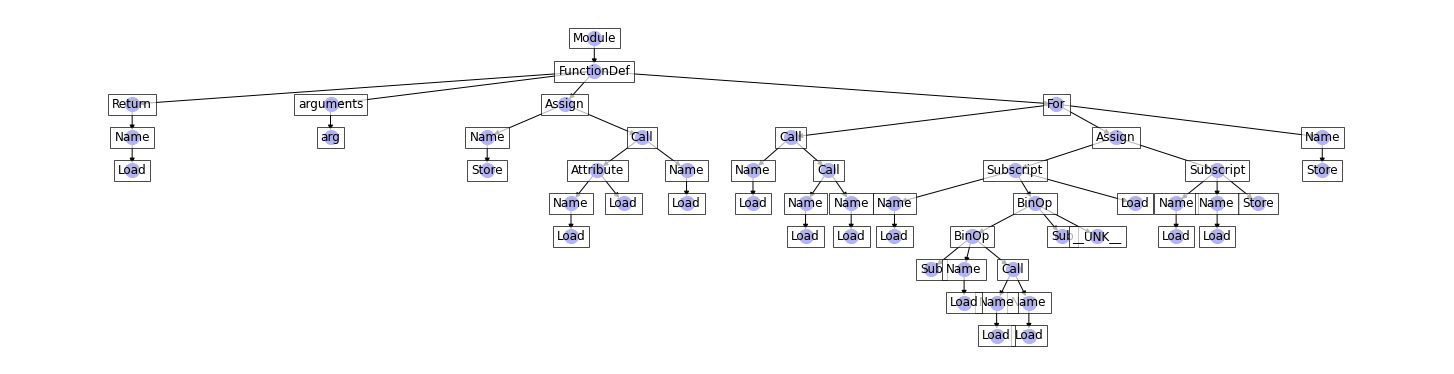

In [8]:
nx_graph = dgl_graph.to_networkx()

pos = hierarchy_pos(nx_graph, 0, width=2.)
plt.figure(figsize=(20,5))
nx.draw(nx_graph, pos, with_labels=True, node_size=200, node_color="blue", edge_color="black")
nx.draw_networkx_labels(
    nx_graph, 
    pos, 
    {
        i: val for i, val in enumerate(idx2type.iloc[graph_dict["node_feat"][:, 0]].type)
    }, 
    bbox={"ec": "k", "fc": "white", "alpha": 0.7}
)
plt.show()

In [9]:
augment_edge(dgl_graph)

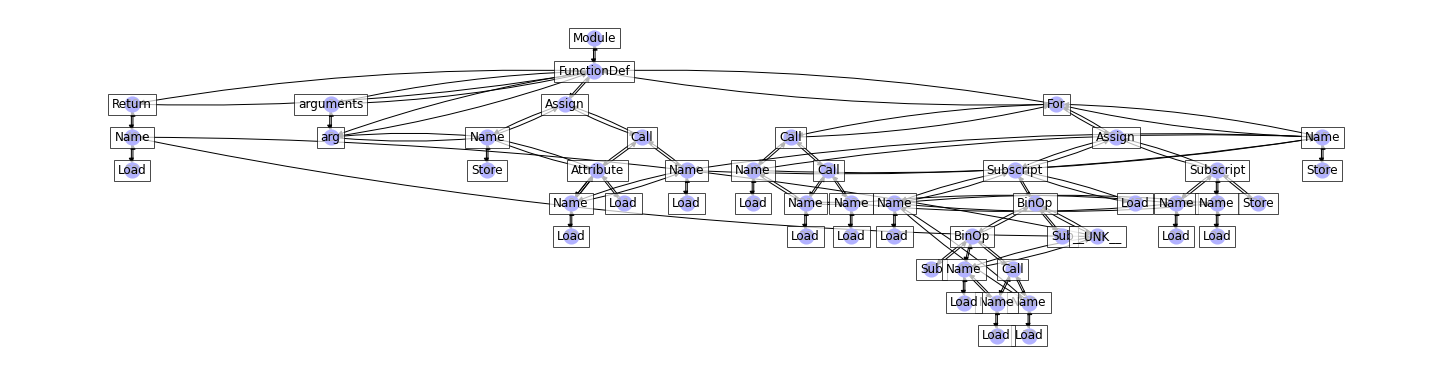

In [10]:
nx_graph = dgl_graph.to_networkx()

plt.figure(figsize=(20,5))
nx.draw(
    nx_graph, 
    pos, 
    with_labels=True, node_size=200, node_color="blue", edge_color="black",
    connectionstyle='arc3, rad=0.05', 
    arrowsize = 10, linewidths = 2
)
nx.draw_networkx_labels(
    nx_graph, 
    pos, 
    {
        i: val for i, val in enumerate(idx2type.iloc[graph_dict["node_feat"][:, 0]].type)
    }, 
    bbox={"ec": "k", "fc": "white", "alpha": 0.7},
)
plt.show()

## Vizualising the prediction

In [36]:
state_dict = torch.load("models/gcn_wide/model.pt", map_location=torch.device('cpu'))
model = MethodNamePredictor(5002, 5, ASTNodeEncoder(300, 98, 10030, 20), gnn_type="gcn")
model.load_state_dict(state_dict)
_ = model.eval()

In [37]:
idx = 20
# predictions = model(dgl.batch([train_loader.dataset[idx][0]]))
predictions = model(dgl.batch([dgl_graph]))
# print(train_loader.dataset[idx][1])

In [38]:
for tensor in predictions:
    idxs = tensor.argsort(descending=True)[0][:3]
    for idx in idxs:
        print(idx2vocab[idx], tensor[0, idx].item(),  end=" ")
    print()

get 4.980863571166992 __UNK__ 4.878833770751953 set 3.5250797271728516 
__EOS__ 5.560771465301514 __UNK__ 5.104060649871826 to 3.258223295211792 
__EOS__ 6.523570537567139 __UNK__ 3.98030424118042 to 2.5053019523620605 
__EOS__ 7.132113456726074 __UNK__ 2.9103689193725586 name 1.517531156539917 
__EOS__ 7.524714946746826 __UNK__ 2.092066764831543 name 0.7582862973213196 


## Evaluating the constant network

In [19]:
from ogb.graphproppred import Evaluator
evaluator = Evaluator(name="ogbg-code2")

In [31]:
evaluator_dict = {
    "seq_pred": [["get"] for _ in range(len(test_loader.dataset))],
    "seq_ref": [label for _, label in test_loader.dataset],
}
evaluator.eval(evaluator_dict)

{'precision': 0.10816475305266994,
 'recall': 0.04405832255750243,
 'F1': 0.060836475352604384}